## Task 1

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from scipy import ndimage as ndi

In [10]:
image = cv2.imread('/content/sample_data/Screenshot 2025-04-16 000541.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [11]:
def display_results(original, blobs, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(original)
    ax[0].set_title('Original Image')
    ax[0].set_axis_off()

    ax[1].imshow(original)
    ax[1].set_title(title)

    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
        ax[1].add_patch(c)

    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [12]:
def detect_blobs_log(image, min_sigma=1, max_sigma=30, num_sigma=10, threshold=0.1):
    print("Applying Laplacian of Gaussian (LoG) blob detection...")
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray_img = rgb2gray(image)
    else:
        gray_img = image

    # Detect blobs
    blobs_log = blob_log(gray_img, min_sigma=min_sigma, max_sigma=max_sigma,
                         num_sigma=num_sigma, threshold=threshold)

    # Compute radii in the 3rd column
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

    print(f"LoG method detected {len(blobs_log)} blobs")
    return blobs_log

In [13]:
def detect_blobs_dog(image, min_sigma=1, max_sigma=30, sigma_ratio=1.6, threshold=0.1):
    print("Applying Difference of Gaussian (DoG) blob detection...")
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray_img = rgb2gray(image)
    else:
        gray_img = image

    # Detect blobs
    blobs_dog = blob_dog(gray_img, min_sigma=min_sigma, max_sigma=max_sigma,
                         sigma_ratio=sigma_ratio, threshold=threshold)

    # Compute radii in the 3rd column
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

    print(f"DoG method detected {len(blobs_dog)} blobs")
    return blobs_dog

In [14]:
def detect_features_hog(image, visualize=True):
    print("Applying Histogram of Oriented Gradients (HOG) feature detection...")

    resized = cv2.resize(gray_image, (128, 128))

    fd, hog_image = feature.hog(
        resized,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=visualize,
        block_norm='L2-Hys'
    )


    if hog_image is not None:
        hog_image_normalized = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min())
        hog_image_uint8 = (hog_image_normalized * 255).astype(np.uint8)

        _, binary = cv2.threshold(hog_image_uint8, 50, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        blobs_hog = []
        for contour in contours:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            if radius > 3:
                blobs_hog.append([y, x, radius])

        blobs_hog = np.array(blobs_hog)
        print(f"HOG-based method detected {len(blobs_hog)} blob-like regions")

        plt.figure(figsize=(10, 10))
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Feature Visualization')
        plt.axis('off')
        plt.show()

        return blobs_hog, hog_image

    return None, None

Applying Laplacian of Gaussian (LoG) blob detection...
LoG method detected 404 blobs


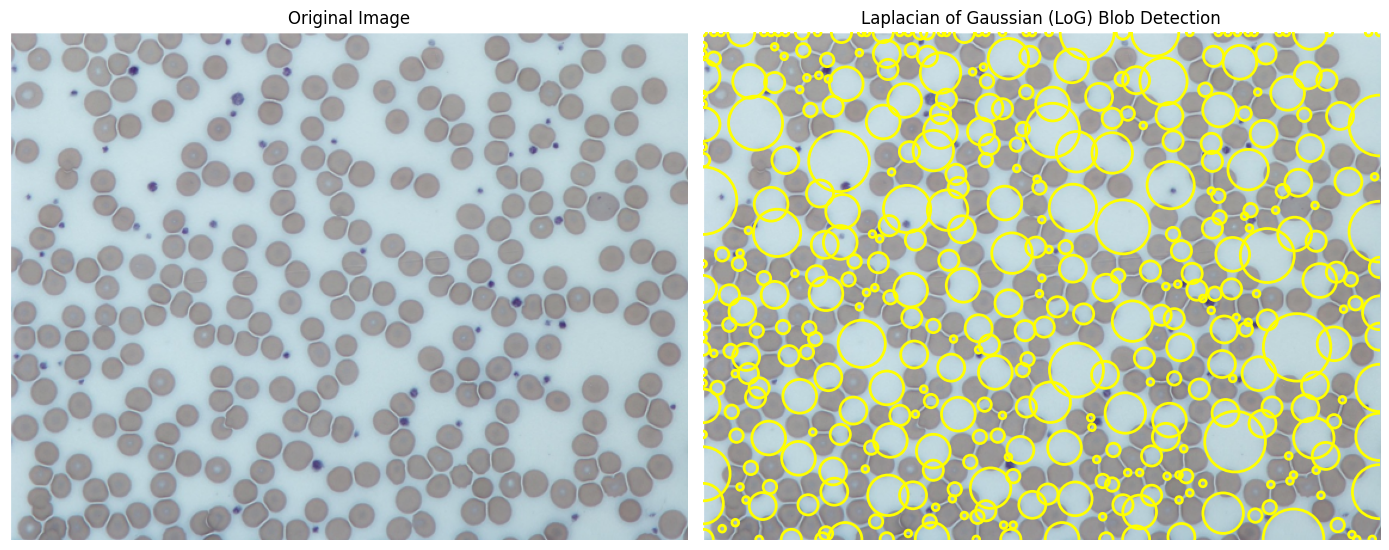

Applying Difference of Gaussian (DoG) blob detection...
DoG method detected 443 blobs


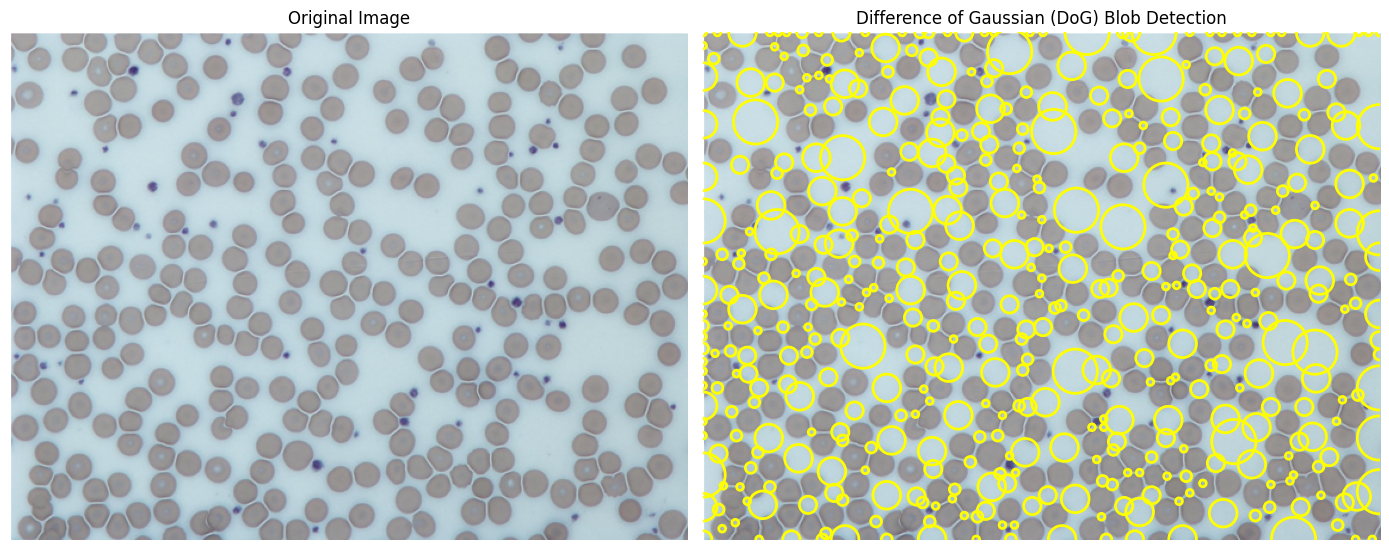

Applying Histogram of Oriented Gradients (HOG) feature detection...
HOG-based method detected 0 blob-like regions


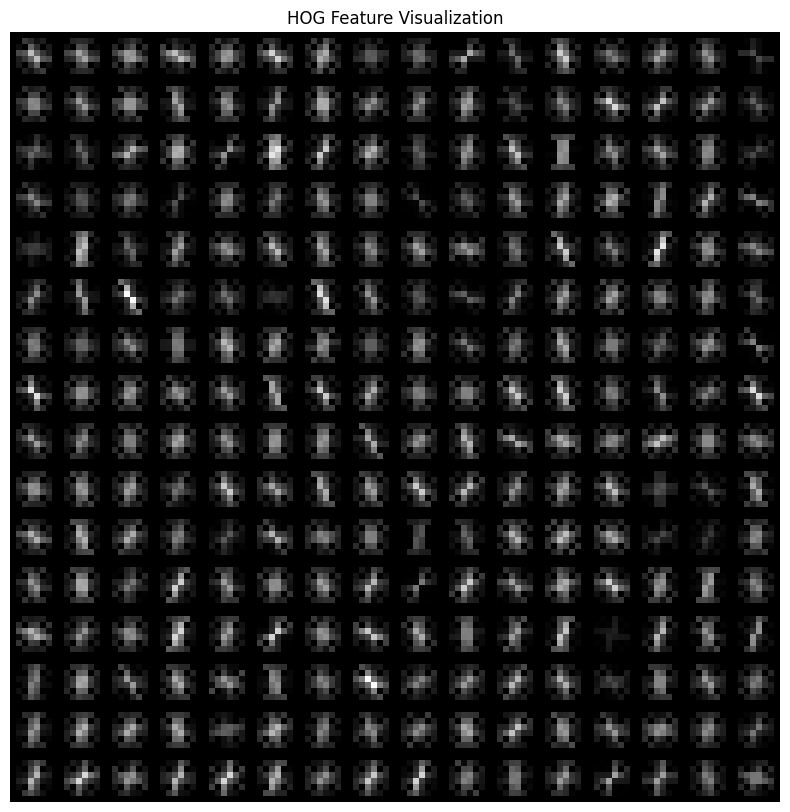

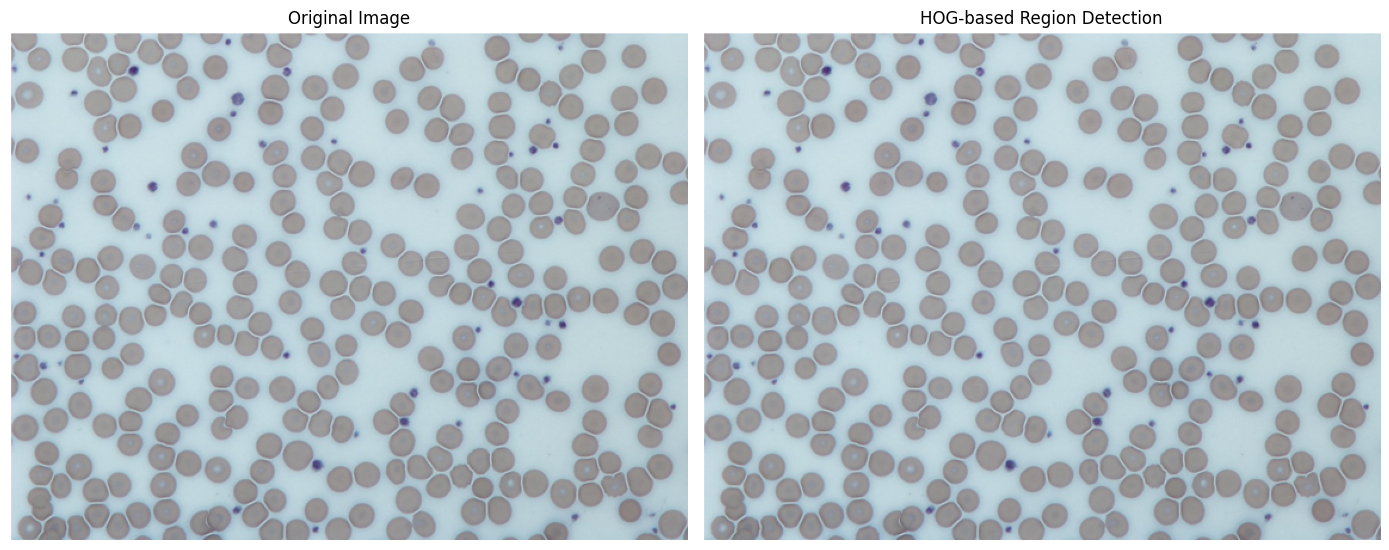

In [15]:
blobs_log = detect_blobs_log(image_rgb, min_sigma=2, max_sigma=20, num_sigma=10, threshold=0.07)
display_results(image_rgb, blobs_log, 'Laplacian of Gaussian (LoG) Blob Detection')

blobs_dog = detect_blobs_dog(image_rgb, min_sigma=2, max_sigma=20, threshold=0.05)
display_results(image_rgb, blobs_dog, 'Difference of Gaussian (DoG) Blob Detection')

blobs_hog, hog_image = detect_features_hog(image_rgb)
if blobs_hog is not None:
    display_results(image_rgb, blobs_hog, 'HOG-based Region Detection')

Detecting platelets by color...
Color-based method detected 23 platelets


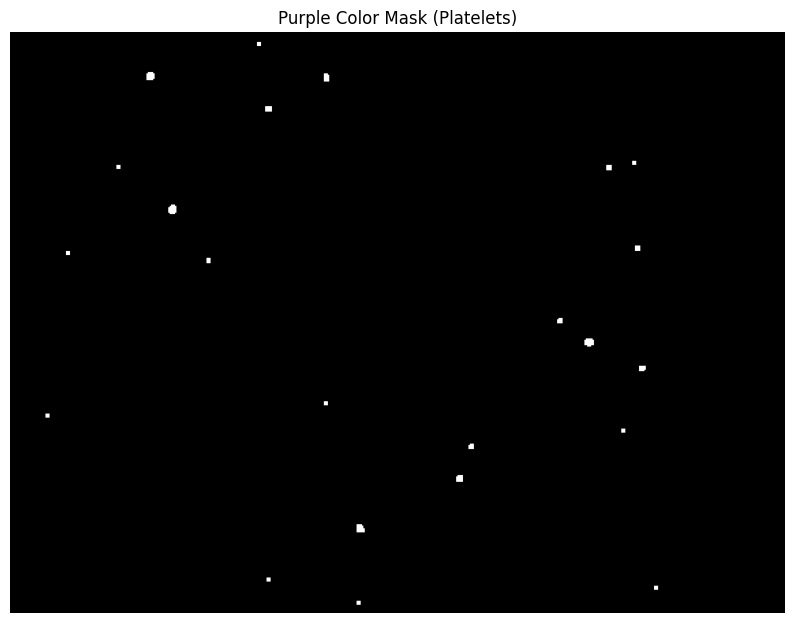

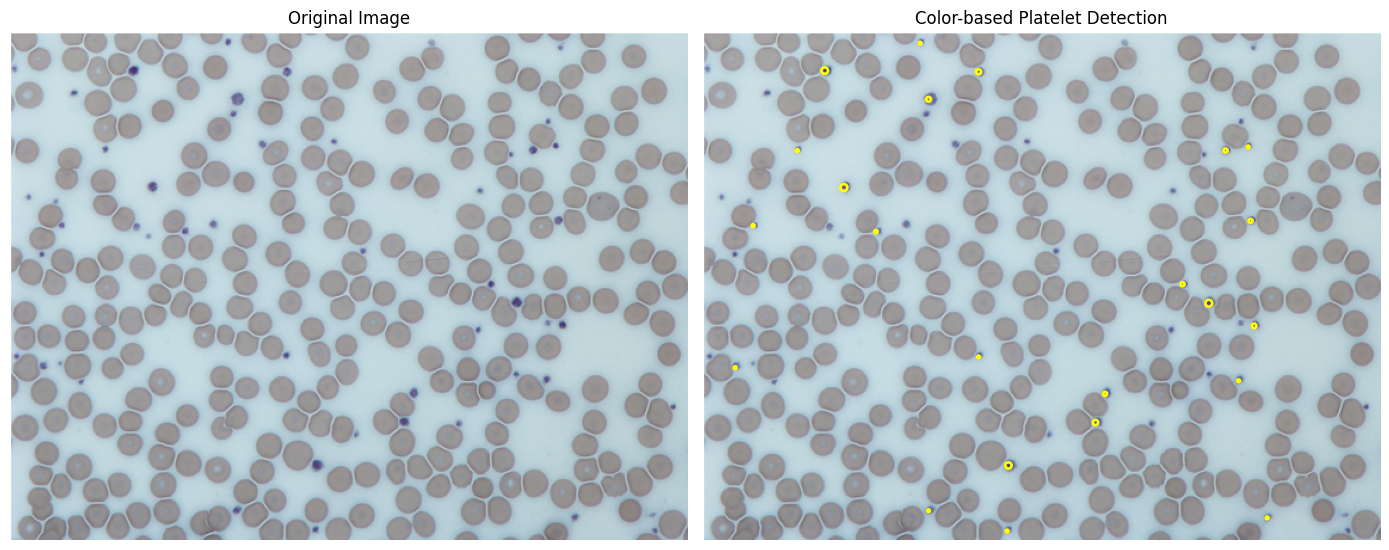

In [16]:
def detect_platelets_by_color(image):
    print("Detecting platelets by color...")
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_purple = np.array([120, 30, 30])
    upper_purple = np.array([170, 255, 255])

    mask = cv2.inRange(hsv, lower_purple, upper_purple)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    platelets = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] > 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
            area = cv2.contourArea(contour)
            radius = np.sqrt(area / np.pi)
            if 1 < radius < 10:  # Filter by size
                platelets.append([center_y, center_x, radius])

    platelets = np.array(platelets)
    print(f"Color-based method detected {len(platelets)} platelets")

    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    plt.title('Purple Color Mask (Platelets)')
    plt.axis('off')
    plt.show()

    return platelets

platelets = detect_platelets_by_color(image_rgb)
if len(platelets) > 0:
    display_results(image_rgb, platelets, 'Color-based Platelet Detection')

Applying Laplacian of Gaussian for candy detection...
LoG method detected 25 candies


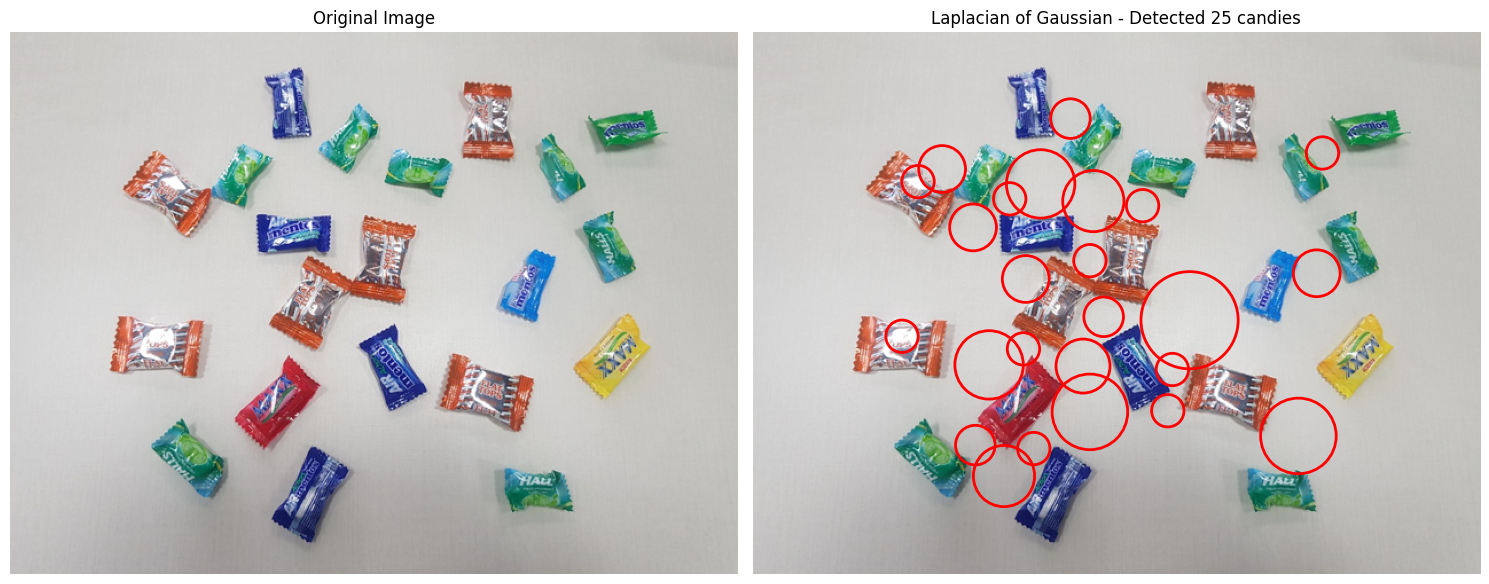

Applying Difference of Gaussian for candy detection...
DoG method detected 56 candies


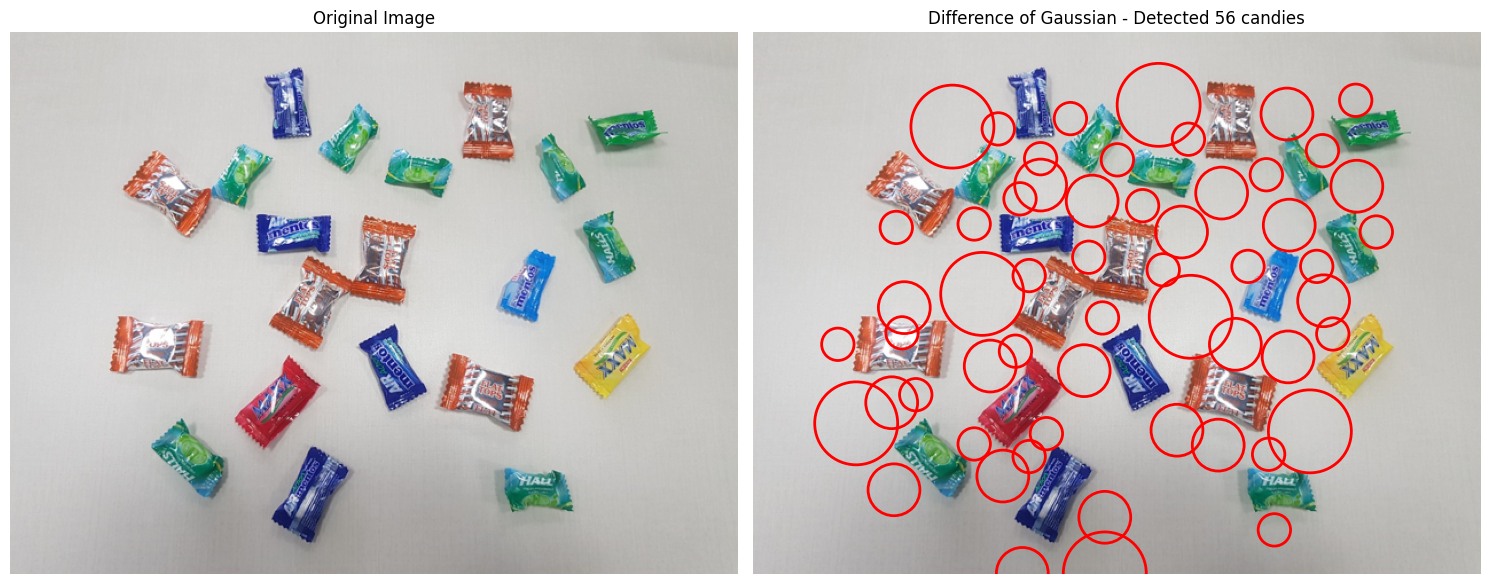

Applying color-based segmentation for candy detection...
Color-based method detected 24 candies


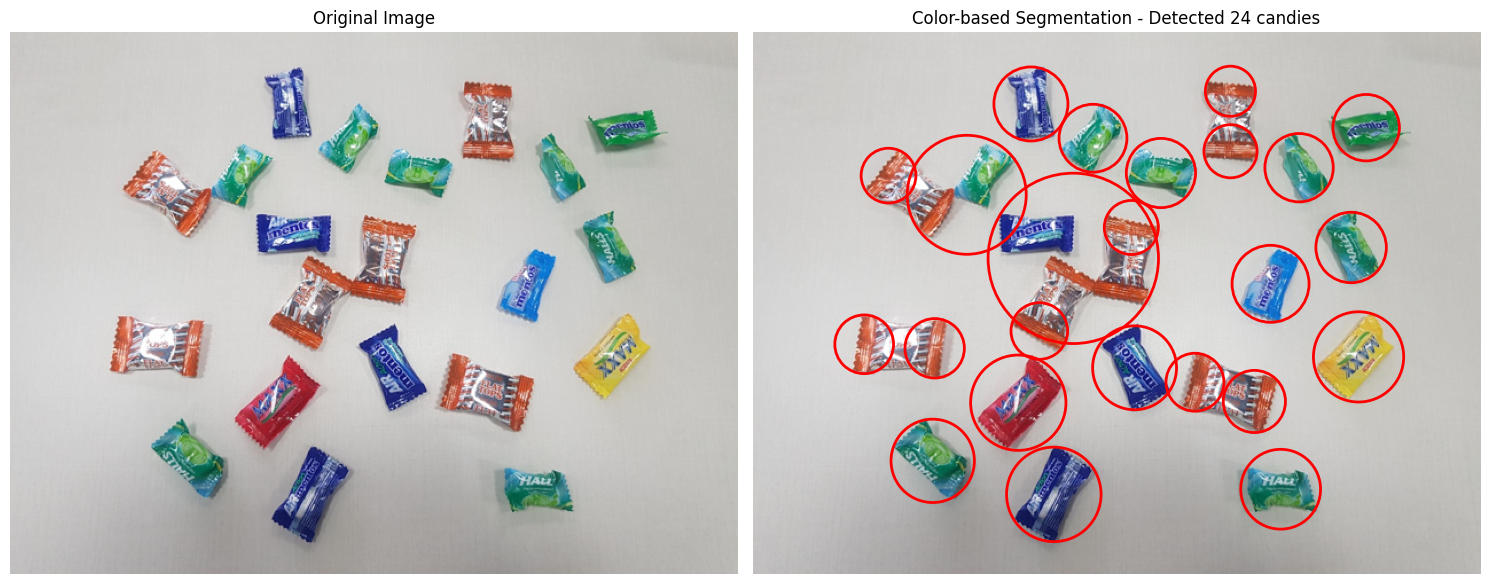

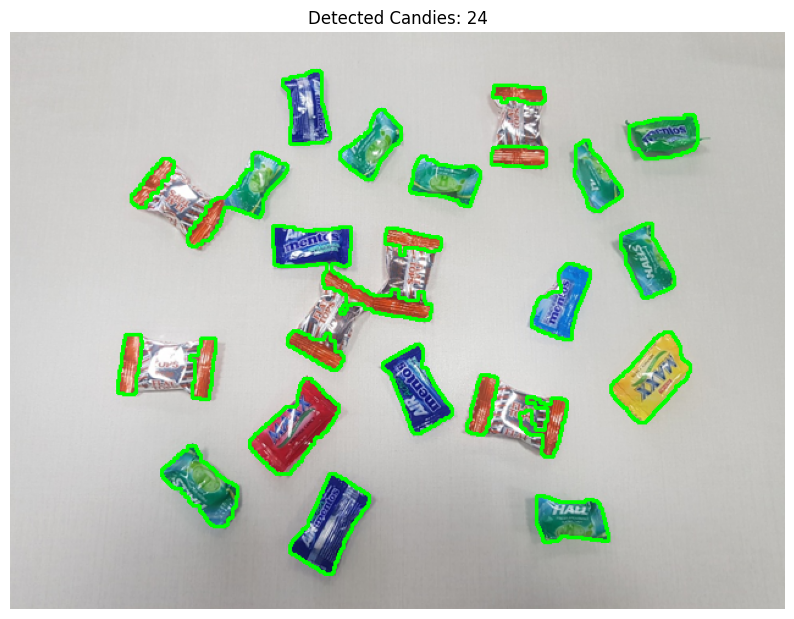

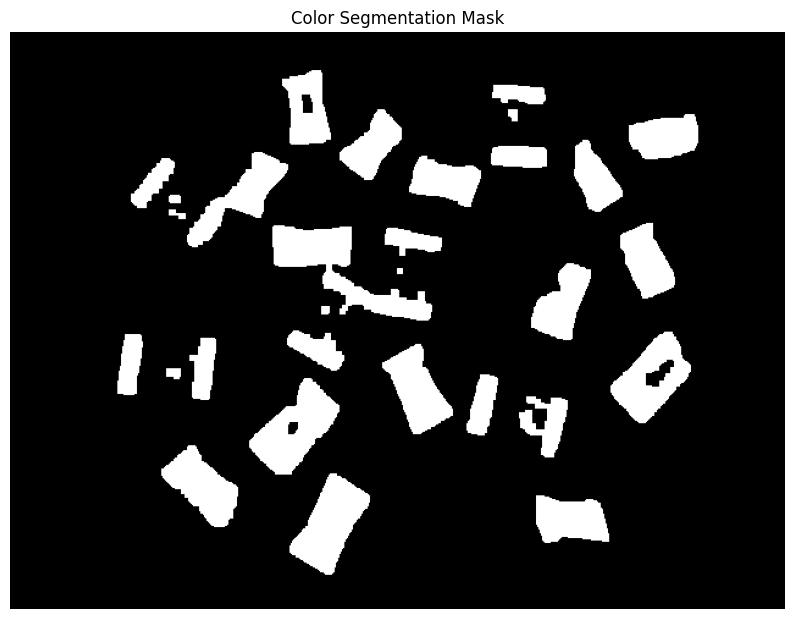


Summary of candy counts by different methods:
LoG Count: 25
DoG Count: 56
Color-based Count: 24
Manual Count: 24


In [18]:

def count_candies(image_path):
    image = cv2.imread('/content/sample_data/Screenshot 2025-04-16 000552.png')
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    def display_results(original, blobs, title):
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        ax[0].imshow(original)
        ax[0].set_title('Original Image')
        ax[0].set_axis_off()

        ax[1].imshow(original)
        ax[1].set_title(f'{title} - Detected {len(blobs)} candies')

        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
            ax[1].add_patch(c)

        ax[1].set_axis_off()
        plt.tight_layout()
        plt.show()

    print("Applying Laplacian of Gaussian for candy detection...")

    min_sigma = 10
    max_sigma = 30
    num_sigma = 10
    threshold = 0.15

    blobs_log = blob_log(enhanced, min_sigma=min_sigma, max_sigma=max_sigma,
                       num_sigma=num_sigma, threshold=threshold)

    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

    print(f"LoG method detected {len(blobs_log)} candies")
    display_results(image_rgb, blobs_log, "Laplacian of Gaussian")

    print("Applying Difference of Gaussian for candy detection...")

    min_sigma = 10
    max_sigma = 30
    sigma_ratio = 1.6
    threshold = 0.05

    blobs_dog = blob_dog(enhanced, min_sigma=min_sigma, max_sigma=max_sigma,
                        sigma_ratio=sigma_ratio, threshold=threshold)

    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

    print(f"DoG method detected {len(blobs_dog)} candies")
    display_results(image_rgb, blobs_dog, "Difference of Gaussian")

    print("Applying color-based segmentation for candy detection...")

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_bound = np.array([0, 30, 30])
    upper_bound = np.array([180, 255, 255])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 500
    max_area = 10000
    filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

    blobs_color = []
    for contour in filtered_contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        blobs_color.append([y, x, radius])

    blobs_color = np.array(blobs_color)

    print(f"Color-based method detected {len(blobs_color)} candies")
    display_results(image_rgb, blobs_color, "Color-based Segmentation")

    result = image_rgb.copy()
    cv2.drawContours(result, filtered_contours, -1, (0, 255, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(result)
    plt.title(f"Detected Candies: {len(filtered_contours)}")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(mask, cmap='gray')
    plt.title("Color Segmentation Mask")
    plt.axis('off')
    plt.show()

    return {
        "LoG Count": len(blobs_log),
        "DoG Count": len(blobs_dog),
        "Color-based Count": len(blobs_color),
        "Manual Count": 24
    }

candy_counts = count_candies("Picture2.jpg")
print("\nSummary of candy counts by different methods:")
for method, count in candy_counts.items():
    print(f"{method}: {count}")

In [19]:
!pip install deeplake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 44.9 MB/s eta 0:00:00


## Task 2

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import deeplake

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:05<00:00, 30.9MB/s]


In [22]:
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    else:
        raise ValueError("Model not supported")

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 100)

    return model


In [23]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model = model.to(device)
    best_acc = 0.0
    training_results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        start_time = time.time()

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(trainset)
        epoch_acc = running_corrects.double() / len(trainset)
        epoch_time = time.time() - start_time

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s')

        training_results['train_loss'].append(epoch_loss)
        training_results['train_acc'].append(epoch_acc.item())

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        start_time = time.time()

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(testset)
        epoch_acc = running_corrects.double() / len(testset)
        epoch_time = time.time() - start_time

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s')

        training_results['val_loss'].append(epoch_loss)
        training_results['val_acc'].append(epoch_acc.item())

        scheduler.step()

        if epoch_acc > best_acc:
            best_acc = epoch_acc

    return model, training_results

In [24]:
def evaluate_model(model_name, model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    inference_times = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(testset)
    epoch_acc = running_corrects.double() / len(testset)
    avg_inference_time = sum(inference_times) / len(inference_times)
    total_inference_time = sum(inference_times)

    results = {
        'model': model_name,
        'accuracy': epoch_acc.item(),
        'loss': epoch_loss,
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time
    }

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {epoch_acc:.4f}")
    print(f"Loss: {epoch_loss:.4f}")
    print(f"Average Inference Time: {avg_inference_time:.6f} seconds")
    print(f"Total Inference Time: {total_inference_time:.4f} seconds")

    return results

In [25]:

def compare_models(results_dict):
    models = list(results_dict.keys())

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for model_name in models:
        plt.plot(results_dict[model_name]['training_results']['train_acc'], label=f'{model_name} Train')
        plt.plot(results_dict[model_name]['training_results']['val_acc'], label=f'{model_name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for model_name in models:
        plt.plot(results_dict[model_name]['training_results']['train_loss'], label=f'{model_name} Train')
        plt.plot(results_dict[model_name]['training_results']['val_loss'], label=f'{model_name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(10, 6))

    x = np.arange(len(models))
    width = 0.35

    accuracies = [results_dict[model]['evaluation_results']['accuracy'] for model in models]
    ax1.bar(x - width/2, accuracies, width, label='Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])

    ax2 = ax1.twinx()
    inference_times = [results_dict[model]['evaluation_results']['avg_inference_time'] for model in models]
    ax2.bar(x + width/2, inference_times, width, color='orange', label='Inference Time')
    ax2.set_ylabel('Inference Time (seconds)')

    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Model Comparison')
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    print("\nModel Comparison:")
    print("-" * 80)
    print(f"{'Model':<10} | {'Accuracy':<10} | {'Loss':<10} | {'Avg Inference Time':<20} | {'Parameter Count':<15}")
    print("-" * 80)

    for model_name in models:
        params = results_dict[model_name]['param_count']
        acc = results_dict[model_name]['evaluation_results']['accuracy']
        loss = results_dict[model_name]['evaluation_results']['loss']
        inf_time = results_dict[model_name]['evaluation_results']['avg_inference_time']

        print(f"{model_name:<10} | {acc:<10.4f} | {loss:<10.4f} | {inf_time:<20.6f} | {params:<15,}")

In [26]:
def run_experiment(num_epochs=10):
    model_names = ['resnet18', 'resnet34']
    results = {}

    for model_name in model_names:
        print(f"\n{'='*20} Training {model_name} {'='*20}")

        model = get_model(model_name)

        param_count = sum(p.numel() for p in model.parameters())
        print(f"Number of parameters: {param_count:,}")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        trained_model, training_results = train_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs
        )

        evaluation_results = evaluate_model(model_name, trained_model, criterion)

        results[model_name] = {
            'model': trained_model,
            'training_results': training_results,
            'evaluation_results': evaluation_results,
            'param_count': param_count
        }

    compare_models(results)

    return results


==================== Training resnet18 ====================


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


Number of parameters: 11,227,812
Epoch 1/5
----------
Train Loss: 1.5880 Acc: 0.5829 Time: 159.97s
Val Loss: 0.9329 Acc: 0.7225 Time: 18.48s
Epoch 2/5
----------
Train Loss: 0.7703 Acc: 0.7691 Time: 160.88s
Val Loss: 0.8139 Acc: 0.7523 Time: 18.49s
Epoch 3/5
----------
Train Loss: 0.5913 Acc: 0.8187 Time: 161.95s
Val Loss: 0.7853 Acc: 0.7607 Time: 18.36s
Epoch 4/5
----------
Train Loss: 0.4595 Acc: 0.8592 Time: 162.24s
Val Loss: 0.7766 Acc: 0.7725 Time: 19.03s
Epoch 5/5
----------
Train Loss: 0.3596 Acc: 0.8898 Time: 162.26s
Val Loss: 0.7515 Acc: 0.7783 Time: 19.67s

Model: resnet18
Accuracy: 0.7783
Loss: 0.7515
Average Inference Time: 0.009230 seconds
Total Inference Time: 0.7292 seconds

==================== Training resnet34 ====================


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


Number of parameters: 21,335,972
Epoch 1/5
----------
Train Loss: 1.3708 Acc: 0.6275 Time: 261.62s
Val Loss: 0.8699 Acc: 0.7355 Time: 21.03s
Epoch 2/5
----------
Train Loss: 0.6637 Acc: 0.7973 Time: 261.89s
Val Loss: 0.7810 Acc: 0.7655 Time: 20.69s
Epoch 3/5
----------
Train Loss: 0.4912 Acc: 0.8459 Time: 262.46s
Val Loss: 0.7108 Acc: 0.7859 Time: 21.58s
Epoch 4/5
----------
Train Loss: 0.3816 Acc: 0.8797 Time: 263.62s
Val Loss: 0.6987 Acc: 0.7952 Time: 21.26s
Epoch 5/5
----------
Train Loss: 0.3001 Acc: 0.9053 Time: 262.10s
Val Loss: 0.6834 Acc: 0.7999 Time: 20.81s

Model: resnet34
Accuracy: 0.7999
Loss: 0.6834
Average Inference Time: 0.014666 seconds
Total Inference Time: 1.1586 seconds


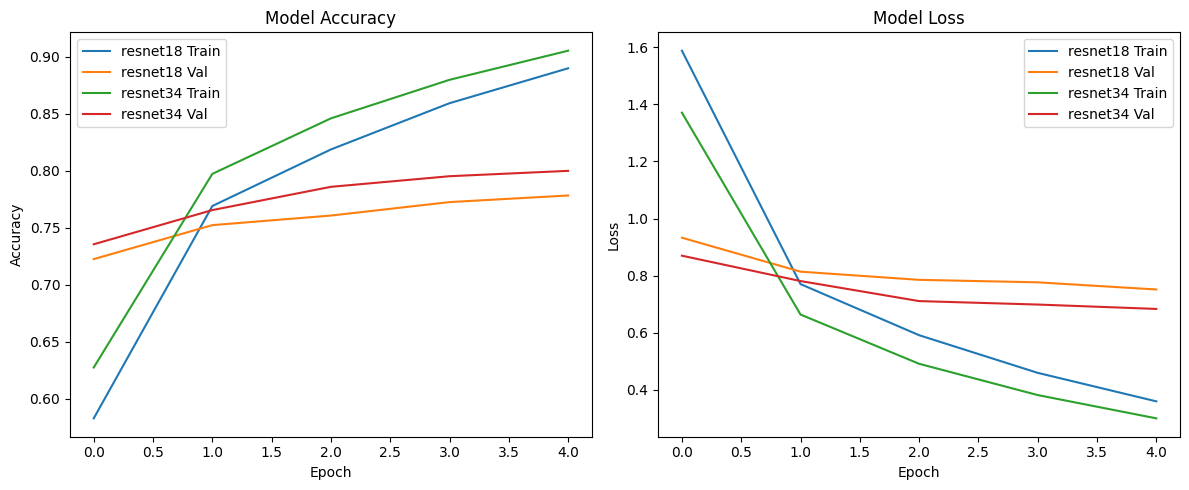

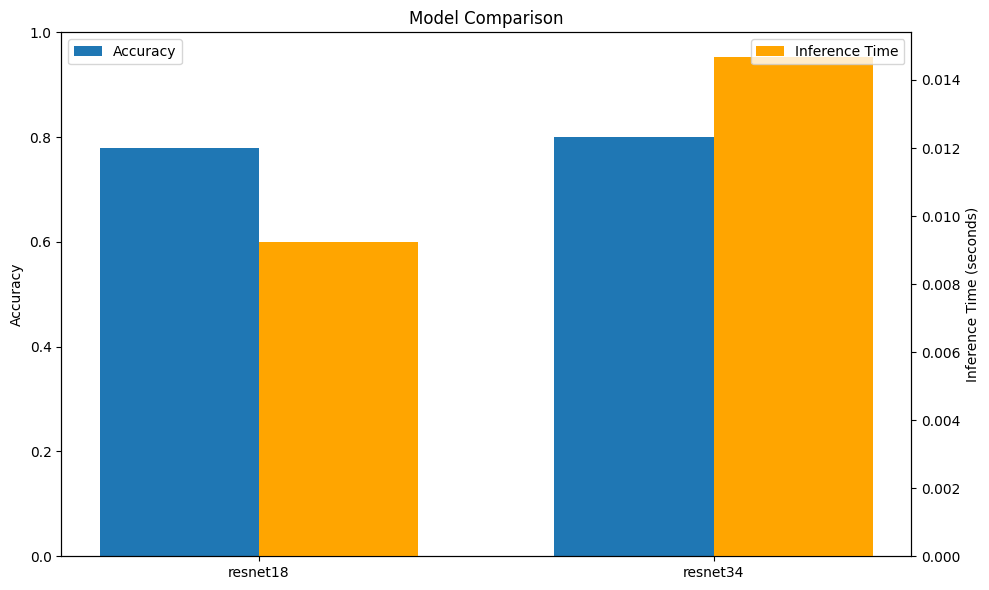


Model Comparison:
--------------------------------------------------------------------------------
Model      | Accuracy   | Loss       | Avg Inference Time   | Parameter Count
--------------------------------------------------------------------------------
resnet18   | 0.7783     | 0.7515     | 0.009230             | 11,227,812     
resnet34   | 0.7999     | 0.6834     | 0.014666             | 21,335,972     


In [27]:
results = run_experiment(num_epochs=5)